# PCA analysis number of components needed to preserve diffusion

In [1]:
# import relevant modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import time
import sys
%matplotlib inline

from dipy.core.sphere import disperse_charges, HemiSphere
from dipy.core.gradients import gradient_table
from dipy.sims.voxel import multi_tensor
import dipy.reconst.dti as dti
import dipy.reconst.dki as dki

from pca_utils import (rfiw_phantom, mp_distribution, fiber_segments_phantom)

First let analyse the PCA information of the fiber immersed in water phantom. This numerical phantom was mathematicaly derived for simple evaluation of diffusion weighted techniques. Although the phantom is only based in one uniform fiber boundle immersed in water, it takes into account fiber heteregoneity by seperately modeling restricted and hindered diffusion components. The phantom also includes free water partial volume effects of voxels located in the boundary between fiber and water.

To see how PCA preserves multi-shell information, we artificially generate the data of this phantom based on b-value multi-shell data. The acquisition parameters considered consited on 6 b-values = 0, 8 uniform samples gradient directions for b-value 300 s.mm-2, 30 directions for b-value 1000 s.mm-2, and 60 directions for b-value 2000 s.mm-2.

In [2]:
# ---------------------------------------------------------------
# acquisition parameters
# ---------------------------------------------------------------

# Sample 8 diffusion-weighted directions for first shell
n_pts = 8
theta = np.pi * np.random.rand(n_pts)
phi = 2 * np.pi * np.random.rand(n_pts)
hsph_initial = HemiSphere(theta=theta, phi=phi)
hsph_updated, potential = disperse_charges(hsph_initial, 5000)
directions8 = hsph_updated.vertices  # directions for each shell

# Sample 30 diffusion-weighted directions for second shell
n_pts = 30
theta = np.pi * np.random.rand(n_pts)
phi = 2 * np.pi * np.random.rand(n_pts)
hsph_initial = HemiSphere(theta=theta, phi=phi)
hsph_updated, potential = disperse_charges(hsph_initial, 50000)
directions30 = hsph_updated.vertices  # directions for each shell

# Sample 60 diffusion-weighted directions for second shell
n_pts = 60
theta = np.pi * np.random.rand(n_pts)
phi = 2 * np.pi * np.random.rand(n_pts)
hsph_initial = HemiSphere(theta=theta, phi=phi)
hsph_updated, potential = disperse_charges(hsph_initial, 50000)
directions60 = hsph_updated.vertices  # directions for each shell

# Create full dataset parameters
bvals = np.hstack((np.zeros(6), 300 * np.ones(8),
                   1000 * np.ones(30), 2000 * np.ones(60)))
bvecs = np.vstack((np.zeros((6, 3)), directions8, directions30, directions60))
gtab = gradient_table(bvals, bvecs)

With the acquisition parameters defined and saved in the gradient table gtab, the phanton data is generated using function rfiw_phantom. Artificial rician noise is added with an nominal SNR of 30 (this snr is defined relative to the water component).

In [3]:
snr = 30
DWI = rfiw_phantom(gtab, snr=snr, noise_type='rician')

So let analyse how many principal components are relevant for this phantom. For this we compute the eigenvalues of the convariance signal relative to a voxel corresponding to a voxel containing fiber. 

In [4]:
psize = 2
m = (2*psize + 1) ** 3
n = DWI.shape[3]
k = j = i = 5
X = DWI[i - psize: i + psize + 1, j - psize: j + psize + 1,
        k - psize: k + psize + 1, :]
X = X.reshape(m, n)
M = np.mean(X, axis=0)
X = X - M
[L, W] = np.linalg.eigh(np.dot(X.T, X)/m)
print(L)

[  3.91975878e-02   7.16813838e-02   1.74808254e-01   1.89337406e-01
   2.50800194e-01   2.90669573e-01   3.67519982e-01   3.77748242e-01
   4.43578822e-01   5.30659831e-01   6.47978250e-01   7.31836004e-01
   8.00559751e-01   9.48859179e-01   1.03865879e+00   1.06869985e+00
   1.11420059e+00   1.23352015e+00   1.30156045e+00   1.43896413e+00
   1.48052951e+00   1.60969379e+00   1.70419840e+00   1.82267933e+00
   1.95610246e+00   2.09379454e+00   2.24433450e+00   2.32259055e+00
   2.44579693e+00   2.53359353e+00   2.78834183e+00   2.92426358e+00
   3.00588466e+00   3.14430830e+00   3.17862028e+00   3.35262378e+00
   3.50106128e+00   3.65144273e+00   3.75913933e+00   4.02308914e+00
   4.17631234e+00   4.55988623e+00   4.68666207e+00   4.90934948e+00
   4.96972985e+00   5.22151141e+00   5.77299411e+00   5.80171548e+00
   5.98292401e+00   6.06772176e+00   6.46753009e+00   6.72047038e+00
   6.76717683e+00   7.13417013e+00   7.60389339e+00   7.76638935e+00
   8.04975018e+00   8.23755684e+00

Only one eigenvalue has an intensity one order of magnitude larger that the others. This tell us that the signal of the selected phantom voxels can be reconstructed based only in one principal component. This make sense since the parameters of phantom were assumed to be uniform. All other eigenvalues are related to data noise. According to the Marchenko–Pastur law the eigenvalues related to noise signals are described by the Marchenko–Pastur distribution. To confirm that apart from the higher eigenvalue all others are related to noise, below we mark all eigenvalues related to the theorically marchenko-pastur distribution.

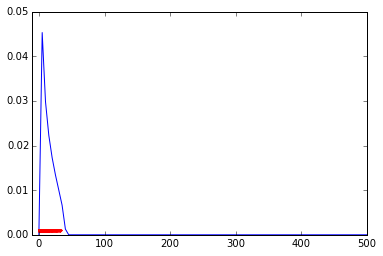

In [5]:
sigma = 100.0/snr
sig2 = sigma ** 2
y = n*1.0/m
x = np.linspace(0, 500, num=100)
p = mp_distribution(x, sig2, y)
plt.plot(x, p, 'b', L, 0.001*np.ones(L.shape), '.r')
plt.axis([-10, 500, 0, 0.05])
plt.show()

As illustrated on the above figure all lower eigenvalues range on the non-zero regime of the theoritically MP distribution.

Now I will analyse if assuming the MP distribution one can estimate the noise variance from data. For this lets define the sum of MP distribution sampled given the data's eigenvalue as function of its variance and plot this given an arbituary range of unknow variances. 

1.50428407894


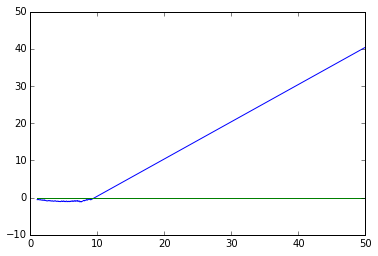

In [6]:
#rmp = lambda v: np.sum(mp_distribution(L, v, y))

# sum of MP distribution samples is not working (I tried also likelihood)
# and momentum fit (mean)
def mp_var_likelihood(x, var, y):
    xpos = var*(1+np.sqrt(y))**2
    #p = mp_distribution(x, var, y)
    return var - np.mean(x[x<xpos])
print mp_var_likelihood(L, sig2, y)

var_samples = np.linspace(1, 50, num=1000)
rmp_samples = np.empty(var_samples.shape)

for i in range(var_samples.size):
    rmp_samples[i] = mp_var_likelihood(L, var_samples[i], y)
plt.plot(var_samples, rmp_samples, var_samples, np.zeros(var_samples.shape))
plt.show()

Eigenvalue mean is equal to the distribution variance

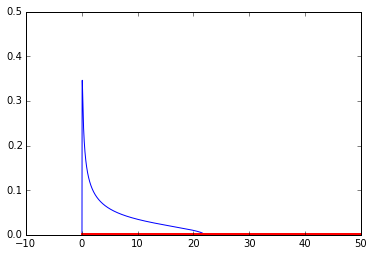

5.99939947152


In [7]:
# This is just to check that mean of MP distribution is
# sigma 2
var = 6
y = n*1.0/m
smax = 50
snum = 10000
x = np.linspace(0, smax, num=snum)
p = mp_distribution(x, var, y)
plt.plot(x, p, 'b', x, 0.001*np.ones(x.shape), '.r')
plt.axis([-10, 50, 0, 0.5])
plt.show()

print(np.sum(x * p) * smax/snum)

## Phantom 2 (Each voxel have different directional information)

Lets analyse how many principal components have a phantom with voxels having different fiber directions.

In [8]:
Phantom = np.zeros((10, 10, 10, gtab.bvals.size))

fiber_sigma = 40.0
n1 = np.random.normal(90, fiber_sigma, size=Phantom.shape[:-1])
n2 = np.random.normal(0, fiber_sigma, size=Phantom.shape[:-1])

ADr = 0.99e-3
RDr = 0.0
ADh = 2.26e-3
RDh = 0.87
S1 = 50
fia = 0.51

mevals = np.array([[ADr, RDr, RDr], [ADh, RDh, RDh]])
fractions = [fia*100, (1-fia) * 100]

for i in range(10):
    for j in range(10):
        for k in range(10):
            angles=[(n1[i, j, k], n2[i, j, k]), (n1[i, j, k], n2[i, j, k])]
            sig, direction = multi_tensor(gtab, mevals, S0=S1, angles=angles,
                                          fractions=[fia*100, (1-fia) * 100],
                                          snr=None)
            print direction
            Phantom[i, j, k, :] = sig 

[[ 0.47587878 -0.54849448 -0.68752686]
 [ 0.47587878 -0.54849448 -0.68752686]]
[[ 0.74594355  0.0632369   0.66300024]
 [ 0.74594355  0.0632369   0.66300024]]
[[ 0.99239789  0.01238479 -0.1224461 ]
 [ 0.99239789  0.01238479 -0.1224461 ]]
[[ 0.70378522 -0.70740853 -0.06526514]
 [ 0.70378522 -0.70740853 -0.06526514]]
[[ 0.47068808 -0.10975915  0.87544598]
 [ 0.47068808 -0.10975915  0.87544598]]
[[ 0.97421998  0.10677875 -0.1987303 ]
 [ 0.97421998  0.10677875 -0.1987303 ]]
[[ 0.25530103  0.12891574  0.95822864]
 [ 0.25530103  0.12891574  0.95822864]]
[[ 0.44611999 -0.08368178  0.89105236]
 [ 0.44611999 -0.08368178  0.89105236]]
[[ 0.23769361  0.61652094  0.75060221]
 [ 0.23769361  0.61652094  0.75060221]]
[[ 0.22449047 -0.33297926  0.9158214 ]
 [ 0.22449047 -0.33297926  0.9158214 ]]
[[ 0.52038652 -0.26565975 -0.81155577]
 [ 0.52038652 -0.26565975 -0.81155577]]
[[ 0.33842387  0.16191915 -0.92695818]
 [ 0.33842387  0.16191915 -0.92695818]]
[[ 0.99094063 -0.03562725  0.12948887]
 [ 0.99094063

In [9]:
Phantom2 = Phantom.copy()

psize = 2
m = (2*psize + 1) ** 3
n = Phantom2.shape[3]
k = j = i = 2
X = Phantom2[i - psize: i + psize + 1, j - psize: j + psize + 1,
             k - psize: k + psize + 1, :]
X = X.reshape(m, n)
M = np.mean(X, axis=0)
X = X - M
[L, W] = np.linalg.eigh(np.dot(X.T, X)/m)
print(L)
Y = X.dot(W[:, -1:])
print(Y.shape)
print W[:, -1:].shape

[  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   2.19875784e-13   6.92134715e-13
   7.65542335e-13   9.87246942e-13   2.37396630e-12   5.63361271e-12
   1.55892936e-11   2.51710009e-11   3.07996809e-11   4.56794426e-11
   9.72222843e-11   1.25638935e-10   1.63306057e-10   2.80771314e-10
   5.48325727e-10   6.81606894e-10   9.04994149e-10   1.69156452e-09
   4.03078790e-09   6.95493774e-09   9.38017625e-09   1.38125274e-08
   2.12768461e-08   3.62786792e-08   6.34098960e-08   1.41934350e-07
   2.18947114e-07   2.62274251e-07   5.42383857e-07   7.43730831e-07
   8.08831773e-07   1.36026239e-06   1.56028410e-06   2.38234469e-06
   2.64937065e-06   4.28874358e-06   4.36905102e-06   5.83354200e-06
   6.84134514e-06   8.53371987e-06   1.14633403e-05   1.25899549e-05
   2.11474890e-05   2.40399582e-05   3.55703028e-05   3.80719476e-05
   5.10146683e-05   5.91250752e-05   1.85822730e-04   2.47677547e-04
   5.04175989e-04   5.07058374e-04

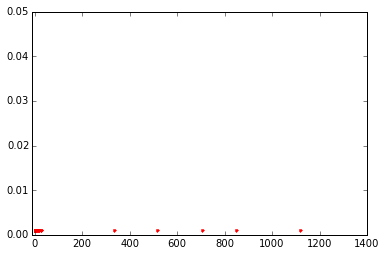

In [10]:
#sigma = 100.0/snr
#sig2 = sigma ** 2
y = n*1.0/m
x = np.linspace(0, 500, num=100)
#p = mp_distribution(x, sig2, y)
#plt.plot(x, p, 'b', L, 0.001*np.ones(L.shape), '.r')
plt.plot(L, 0.001*np.ones(L.shape), '.r')
plt.axis([-10, 1400, 0, 0.05])
plt.show()

Let's analyse the angular error of the denoising strategy as function of the number of components preserved. 

First thing to do is to implement and PCA denoising strategy giving the number of elements to preserve

In [11]:
def localpca(DWI, psize, nep):
    # nep number of elements preserved
    m = (2*psize + 1) ** 3
    n = DWI.shape[3]
    DWIden = np.zeros(DWI.shape)
    for k in range(psize, DWI.shape[2] - psize):
        for j in range(psize, DWI.shape[1] - psize):
            for i in range(psize, DWI.shape[0] - psize):
                X = DWI[i - psize: i + psize + 1, j - psize: j + psize + 1,
                        k - psize: k + psize + 1, :]
                X = X.reshape(m, n)
                M = np.mean(X, axis=0)
                X = X - M
                [L, W] = np.linalg.eigh(np.dot(X.T, X)/m)
                Y = X.dot(W[:, -nep:])
                X = Y.dot(W[:, -nep:].T)
                X = X + M
                X = X.reshape(2*psize + 1, 2*psize + 1, 2*psize + 1, n)
                DWIden[i, j, k, :] = X[psize, psize, psize]
    return DWIden

In [12]:
P2den = localpca(Phantom2, 2, 2)

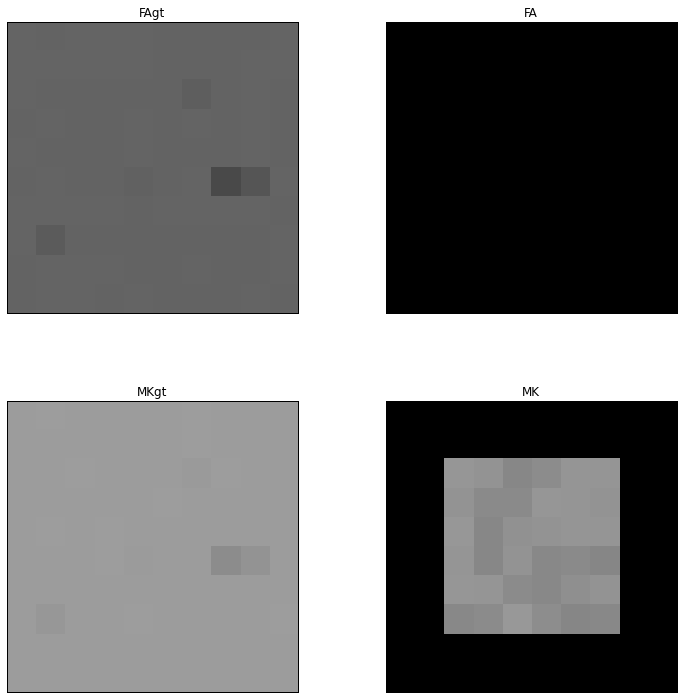

In [13]:
dtiM = dti.TensorModel(gtab)
dkiM = dki.DiffusionKurtosisModel(gtab)

dtiFgt = dtiM.fit(Phantom)
FAgt = dtiFgt.fa
evalsgt = dtiFgt.evals
evecsgt = dtiFgt.evecs
directionsgt = dtiFgt.directions

dkiF = dkiM.fit(Phantom)
MKgt = dkiF.mk()

dtiF = dtiM.fit(P2den)
FA = dtiF.fa
evals = dtiF.evals
evecs = dtiF.evecs
directions = dtiF.directions

dkiF = dkiM.fit(P2den)
MK = dkiF.mk()

fig2, ax = plt.subplots(2, 2, figsize=(12, 12),
                        subplot_kw={'xticks': [], 'yticks': []})

fig2.subplots_adjust(hspace=0.3, wspace=0.3)

ax.flat[0].imshow(FAgt[:, :, 3], cmap='gray', interpolation="nearest", clim=(0.8, 0.9))
ax.flat[0].set_title('FAgt')
ax.flat[1].imshow(FA[:, :, 3], cmap='gray', interpolation="nearest", clim=(0.8, 0.9))
ax.flat[1].set_title('FA')
ax.flat[2].imshow(MKgt[:, :, 3], cmap='gray', interpolation="nearest", clim=(1, 2))
ax.flat[2].set_title('MKgt')
ax.flat[3].imshow(MK[:, :, 3], cmap='gray', interpolation="nearest", clim=(1, 2))
ax.flat[3].set_title('MK')
plt.show()

In [14]:
print FAgt[5, 5, 5]
print FA[5, 5, 5]
print MKgt[5, 5, 5]
print MK[5, 5, 5]
print np.min(FA[FA>0])
print np.max(FA[FA>0])
print np.min(MK[MK>0])
print np.max(MK[MK>0])

0.839011873802
0.231260858
1.61203980753
1.52521773155
0.214204300056
0.822392794151
1.52398753362
1.59745908015


In [15]:
from dipy.reconst.dti import color_fa
from dipy.viz import fvtk
from dipy.data import get_sphere
sphere = get_sphere('symmetric724')

RGBgt = color_fa(FA, evecsgt)

ren = fvtk.ren()

evalsgt3 = evalsgt[:, :, 3:4]
evecsgt3 = evecsgt[:, :, 3:4]

cfagt = RGBgt[:, :, 3:4]

fvtk.add(ren, fvtk.tensor(evalsgt3, evecsgt3, cfagt, sphere))

#print('Saving illustration as tensor_ellipsoids.png')
fvtk.record(ren, n_frames=1, out_path='tensor_ellipsoids_gt.png', size=(600, 600))

In [16]:
fvtk.show(ren, size=(600, 600))

In [17]:
from dipy.reconst.dti import color_fa
from dipy.viz import fvtk
from dipy.data import get_sphere
sphere = get_sphere('symmetric724')

RGB = color_fa(FA, evecs)

ren = fvtk.ren()

evals3 = evals[:, :, 3:4]
evecs3 = evecs[:, :, 3:4]
evalsgt3 = evalsgt[:, :, 3:4]
evecsgt3 = evecsgt[:, :, 3:4]

cfagt = RGBgt[:, :, 3:4]
cfa = RGB[:, :, 3:4]

fvtk.add(ren, fvtk.tensor(evals3, evecs3, cfa, sphere))

#print('Saving illustration as tensor_ellipsoids.png')
fvtk.record(ren, n_frames=1, out_path='tensor_ellipsoids.png', size=(600, 600))

In [18]:
fvtk.show(ren, size=(600, 600))

Lets create the functions to calculate average angular error

In [19]:
def evaluate_directions(directions, gtdirections):
    angle = np.zeros(directions.shape[0:3])
    for i in range(directions.shape[0]):
        for j in range(directions.shape[1]):
            for k in range(directions.shape[0]):
                v1 = directions[i, j, k]
                vr = gtdirections[i, j, k]
                angle[i, j, k] = np.arccos(np.abs(v1.dot(vr.T))) * 180.0 / np.pi
    p1, p2, p3 = np.percentile(angle, [25 , 50, 75])
    return p2, p2 - p1, p3 - p2

def evaluate_metric(m, gtm):
    err = m - gtm
    p1, p2, p3 = np.percentile(err, [25, 50, 75])
    return p2, p2 - p1, p3 - p2

In [20]:
p1, p2, p3 = evaluate_directions(directions[2:-2, 2:-2, 2:-2], directionsgt[2:-2, 2:-2, 2:-2])

I am now ready to run the final analysis

0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9


C:\Users\Rafael\Anaconda\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


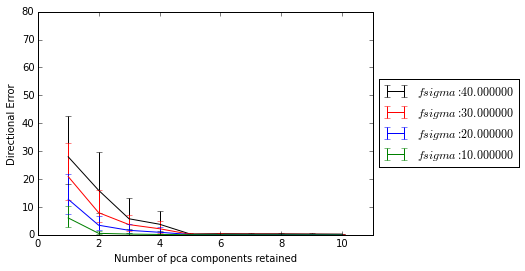

In [21]:
fsigmas = np.array([40.0, 30.0, 20.0, 10.0])
neps = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
lower_p = np.zeros(neps.shape)
higher_p = np.zeros(neps.shape)
median_dir = np.zeros(neps.shape)
colors = {0: 'black', 1: 'r', 2: 'b', 3: 'g'}
for p in range(4):
    Phantom = fiber_segments_phantom(gtab, fsigmas[p])
    dtiFgt = dtiM.fit(Phantom)
    FAgt = dtiFgt.fa
    directionsgt = dtiFgt.directions
    for r in range(neps.size):
        Pden = localpca(Phantom, 2, neps[r])
        dtiF = dtiM.fit(Pden)
        FA = dtiF.fa
        directions = dtiF.directions
        p1, p2, p3 = evaluate_directions(directions[2:-2, 2:-2, 2:-2], directionsgt[2:-2, 2:-2, 2:-2])
        lower_p[r] = p2
        median_dir[r] = p1
        higher_p[r] = p3
        print r
    plt.errorbar(neps, median_dir, yerr=[lower_p, higher_p],
                 color=colors[p], ecolor=colors[p],
                 label='$f sigma: %f$' % fsigmas[p])
plt.axis([0, 11, 0, 80])
plt.xlabel('Number of pca components retained')
plt.ylabel('Directional Error')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

0
1
2
3
4
5
6
7
8
9
10
11
0
1
2
3
4
5
6
7
8
9
10
11
0
1
2
3
4
5
6
7
8
9
10
11
0
1
2
3
4
5
6
7
8
9
10
11


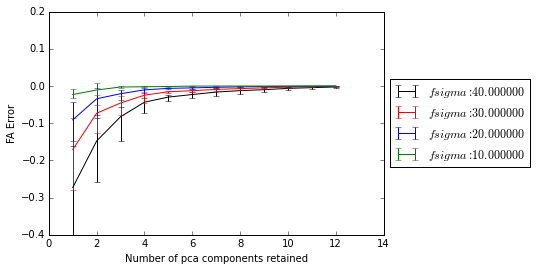

In [22]:
fsigmas = np.array([40.0, 30.0, 20.0, 10.0])
neps = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
lower_p = np.zeros(neps.shape)
higher_p = np.zeros(neps.shape)
median_fa = np.zeros(neps.shape)
colors = {0: 'black', 1: 'r', 2: 'b', 3: 'g'}
for p in range(4):
    Phantom = fiber_segments_phantom(gtab, fsigmas[p])
    dtiFgt = dtiM.fit(Phantom)
    FAgt = dtiFgt.fa
    for r in range(neps.size):
        Pden = localpca(Phantom, 2, neps[r])
        dtiF = dtiM.fit(Pden)
        FA = dtiF.fa
        p1, p2, p3 = evaluate_metric(FA[2:-2, 2:-2, 2:-2], FAgt[2:-2, 2:-2, 2:-2])
        lower_p[r] = p2
        median_fa[r] = p1
        higher_p[r] = p3
        print r
    plt.errorbar(neps, median_fa, yerr=[lower_p, higher_p],
                 color=colors[p], ecolor=colors[p],
                 label='$f sigma: %f$' % fsigmas[p])
plt.axis([0, 14, -0.4, 0.2])
plt.xlabel('Number of pca components retained')
plt.ylabel('FA Error')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [23]:
Phantom = fiber_segments_phantom(gtab, 40)
dtiFgt = dtiM.fit(Phantom)
FAgt = dtiFgt.fa
Pden = localpca(Phantom, 2, 7)
dtiF = dtiM.fit(Pden)
FA = dtiF.fa
p1, p2, p3 = evaluate_metric(FA[2:-2, 2:-2, 2:-2], FAgt[2:-2, 2:-2, 2:-2])

In [24]:
p1

-0.017292529519550293

In [25]:
p2

0.0091124307478168687

In [26]:
p3

0.0071003287801531256

0
1
2
3
4
5
6
7
8
9
10
11
0
1
2
3
4
5
6
7
8
9
10
11
0
1
2
3
4
5
6
7
8
9
10
11
0
1
2
3
4
5
6
7
8
9
10
11


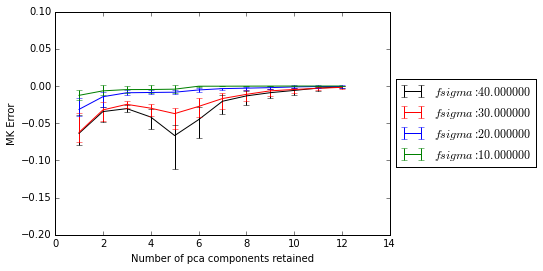

In [27]:
fsigmas = np.array([40.0, 30.0, 20.0, 10.0])
neps = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
lower_p = np.zeros(neps.shape)
higher_p = np.zeros(neps.shape)
median_mk = np.zeros(neps.shape)
colors = {0: 'black', 1: 'r', 2: 'b', 3: 'g'}
for p in range(4):
    Phantom = fiber_segments_phantom(gtab, fsigmas[p])
    dkiFgt = dkiM.fit(Phantom)
    MKgt = dkiFgt.mk()
    for r in range(neps.size):
        Pden = localpca(Phantom, 2, neps[r])
        dkiF = dkiM.fit(Pden)
        MK = dkiF.mk()
        p1, p2, p3 = evaluate_metric(MK[2:-2, 2:-2, 2:-2], MKgt[2:-2, 2:-2, 2:-2])
        lower_p[r] = p2
        median_mk[r] = p1
        higher_p[r] = p3
        print r
    plt.errorbar(neps, median_mk, yerr=[lower_p, higher_p],
                 color=colors[p], ecolor=colors[p],
                 label='$f sigma: %f$' % fsigmas[p])
plt.axis([0, 14, -0.2, 0.1])
plt.xlabel('Number of pca components retained')
plt.ylabel('MK Error')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()